#Transformación de dataset

In [ ]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv('weather.csv',encoding='latin-1')
print(df.head())
# Reemplazar valores nulos en columnas específicas con la media
columns_to_fillna = ['Temperatura_Mínima','Temperatura_Máxima','Precipitación','Evaporación','Horas_de_Sol','Velocidad_ráfaga_viento', 'Velocidad_viento_9am','Velocidad_viento_3pm',
                     'Humedad_9am', 'Humedad_3pm', 'Presión_9am', 'Presión_3pm', 'Nubosidad_9am', 'Nubosidad_3pm',
                     'Temperatura_9am', 'Temperatura_3pm']
df[columns_to_fillna] = df[columns_to_fillna].fillna(df[columns_to_fillna].mean())

# Convertir la columna de fecha a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

# Eliminar duplicados
df = df.drop_duplicates()

# Codificar variables categóricas
df = pd.get_dummies(df, columns=['Ubicación', 'Dirección_ráfaga_viento', 'Dirección_viento_9am', 'Dirección_viento_3pm'])

# Eliminar columnas no necesarias
columns_to_drop = ['Evaporación']  # Agrega aquí las columnas que deseas eliminar
df = df.drop(columns=columns_to_drop, axis=1)

# Normalizar variables (por ejemplo, utilizando Min-Max scaling)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Temperatura_Mínima', 'Temperatura_Máxima', 'Precipitación', 'Horas_de_Sol',
    'Velocidad_ráfaga_viento', 'Velocidad_viento_9am', 'Velocidad_viento_3pm',
    'Humedad_9am', 'Humedad_3pm', 'Presión_9am', 'Presión_3pm', 'Nubosidad_9am',
    'Nubosidad_3pm', 'Temperatura_9am', 'Temperatura_3pm']] = scaler.fit_transform(df[['Temperatura_Mínima', 'Temperatura_Máxima', 'Precipitación', 'Horas_de_Sol',
    'Velocidad_ráfaga_viento', 'Velocidad_viento_9am', 'Velocidad_viento_3pm',
    'Humedad_9am', 'Humedad_3pm', 'Presión_9am', 'Presión_3pm', 'Nubosidad_9am',
    'Nubosidad_3pm', 'Temperatura_9am', 'Temperatura_3pm']])


# Visualizar las primeras filas del dataset limpio
print(df.head())

# Guardar el dataset limpio
df.to_csv('weather_clean.csv', index=False)

        Fecha Ubicación  Temperatura_Mínima  Temperatura_Máxima  \
0  01/12/2008    ufepam                13.4                22.9   
1  02/12/2008    ufepam                 7.4                25.1   
2  03/12/2008    ufepam                12.9                25.7   
3  04/12/2008    ufepam                 9.2                28.0   
4  05/12/2008    ufepam                17.5                32.3   

   Precipitación  Evaporación  Horas_de_Sol Dirección_ráfaga_viento  \
0            0.6          NaN           NaN                       W   
1            0.0          NaN           NaN                     WNW   
2            0.0          NaN           NaN                     WSW   
3            0.0          NaN           NaN                      NE   
4            1.0          NaN           NaN                       W   

   Velocidad_ráfaga_viento Dirección_viento_9am  ... Humedad_9am  Humedad_3pm  \
0                     44.0                    W  ...        71.0         22.0   
1       

In [ ]:
!pip install unidecode
from unidecode import unidecode

# Cargar el conjunto de datos
df = pd.read_csv('weather_clean.csv')  # Asegúrate de tener el nombre correcto del archivo

# Quitar acentos de los nombres de las columnas
df.columns = [unidecode(col) for col in df.columns]

# Visualizar las primeras filas del conjunto de datos con los nombres de columnas actualizados
print(df.head())

# Guardar el conjunto de datos con los nombres de columnas actualizados
df.to_csv('weather_clean_no_accent.csv', index=False)

#EDA

In [ ]:
!pip install pyspark
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WeatherAnalysis").getOrCreate()
df = spark.read.csv("weather_clean.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("weather_data")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=de051c1c14a130fd9bb341499e8962175d43d890c1a1283e9910c998231df403
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Temperatura máxima y mínima

In [ ]:
result_avg_temp = spark.sql("SELECT AVG(Temperatura_Minima) AS avg_temp_min, AVG(Temperatura_Maxima) AS avg_temp_max FROM weather_data")
result_avg_temp.show()

+------------------+------------------+
|      avg_temp_min|      avg_temp_max|
+------------------+------------------+
|0.4880668486077552|0.5297041261937112|
+------------------+------------------+



Total de días lluviosos

In [ ]:
result_rainy_days = spark.sql("SELECT COUNT(*) AS rainy_days FROM weather_data WHERE Lluvia_hoy = 'Yes'")
result_rainy_days.show()

+----------+
|rainy_days|
+----------+
|     31880|
+----------+



Días más cálidos y más fríos:

In [ ]:
result_hottest_days = spark.sql("SELECT Fecha, Temperatura_Maxima FROM weather_data ORDER BY Temperatura_Maxima DESC LIMIT 5")
result_coldest_days = spark.sql("SELECT Fecha, Temperatura_Minima FROM weather_data ORDER BY Temperatura_Minima ASC LIMIT 5")
result_hottest_days.show()
result_coldest_days.show()

+----------+------------------+
|     Fecha|Temperatura_Maxima|
+----------+------------------+
|2011-01-25|               1.0|
|2014-01-03|0.9848771266540642|
|2017-02-12|0.9848771266540642|
|2017-02-11|0.9792060491493384|
|2017-02-11|0.9773156899810964|
+----------+------------------+

+----------+------------------+
|     Fecha|Temperatura_Minima|
+----------+------------------+
|2009-06-11|               0.0|
|2011-07-29|0.0070754716981132|
|2015-08-04|0.0070754716981132|
|2010-06-29|0.0117924528301886|
|2011-07-29|0.0117924528301886|
+----------+------------------+



Días con mayor y menor precipitación:

In [ ]:
result_rainiest_days = spark.sql("SELECT Fecha, Precipitacion FROM weather_data ORDER BY Precipitacion DESC LIMIT 5")
result_driest_days = spark.sql("SELECT Fecha, Precipitacion FROM weather_data WHERE Precipitacion > 0 ORDER BY Precipitacion ASC LIMIT 5")
result_rainiest_days.show()
result_driest_days.show()


+----------+------------------+
|     Fecha|     Precipitacion|
+----------+------------------+
|2009-11-07|               1.0|
|2011-02-16|0.9908355795148248|
|2009-01-12|0.7504043126684636|
|2011-02-04|0.7239892183288411|
|2015-02-08|0.6663072776280323|
+----------+------------------+

+----------+-----------------+
|     Fecha|    Precipitacion|
+----------+-----------------+
|2013-08-01|2.695417789757E-4|
|2015-02-13|2.695417789757E-4|
|2013-09-11|2.695417789757E-4|
|2015-07-10|2.695417789757E-4|
|2013-08-02|2.695417789757E-4|
+----------+-----------------+



Días con cambios bruscos en la velocidad del viento:


In [ ]:
result_wind_change = spark.sql("SELECT Fecha, (Velocidad_viento_3pm - Velocidad_viento_9am) AS wind_change FROM weather_data ORDER BY wind_change DESC LIMIT 5")
result_wind_change.show()

+----------+------------------+
|     Fecha|       wind_change|
+----------+------------------+
|2011-08-05| 0.896551724137931|
|2012-08-17|0.7471264367816092|
|2011-09-20|0.7471264367816092|
|2013-10-29|0.7087533156498674|
|2013-10-13|  0.67789566755084|
+----------+------------------+



Días con mayor cambio de temperatura

In [ ]:
result_temp_change = spark.sql("SELECT Fecha, (Temperatura_Maxima - Temperatura_Minima) AS temp_change FROM weather_data ORDER BY temp_change DESC LIMIT 5")
result_temp_change.show()

+----------+-------------------+
|     Fecha|        temp_change|
+----------+-------------------+
|2011-06-07| 0.4683833714767212|
|2009-10-01| 0.4448050790027464|
|2016-11-05|  0.443400684809359|
|2012-02-24| 0.4426070906302387|
|2009-08-31|0.43064752242011745|
+----------+-------------------+



Días con Horas de Sol Bajas

In [ ]:
query = spark.sql("""
SELECT COUNT(*) AS Low_Sunlight_Days FROM weather_data WHERE Horas_de_Sol < 6;
""")
query.show()

+-----------------+
|Low_Sunlight_Days|
+-----------------+
|           145460|
+-----------------+



# Comparación entre modelos

## Importación de librerías para el proyecto

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

## Preprocesamiento de Datos y División en Conjuntos de Entrenamiento y Prueba

In [ ]:
# Cargar los datos

df = pd.read_csv('/weather.csv')

# Conversión de columnas de fecha
df['C_1'] = pd.to_datetime(df['C_1'])
df['Año'] = df['C_1'].dt.year
df['Mes'] = df['C_1'].dt.month
df['Día'] = df['C_1'].dt.day

# Limpieza de datos: Rellenar valores faltantes
df.fillna(method='ffill', inplace=True)

# Identificar columnas numéricas y categóricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('C_23')  # Asumiendo que 'C_23' es la columna objetivo

# Preprocesamiento de columnas
preprocessorLR = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Preprocesamiento de columnas
preprocessorRF = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Preprocesamiento de columnas
preprocessorDT = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

# Convertir la columna objetivo a valores binarios
df['C_23'] = df['C_23'].map({'Yes': 1, 'No': 0})

# Separar las características y el objetivo
X = df.drop('C_23', axis=1)
y = df['C_23']

# Dividir en conjuntos de entrenamiento y prueba para cada modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

## Construcción de Pipelines y entrenamiento de los modelos

In [ ]:
# Crear y ajustar el pipeline de regresión logística
pipelineLR = Pipeline(steps=[('preprocessor', preprocessorLR),
                           ('classifier', LogisticRegression(max_iter=1000, C=1.0))])


# Entrenar el modelo de regresión logística
pipelineLR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['C_3', 'C_4', 'C_5', 'C_6',
                                                   'C_7', 'C_9', 'C_12', 'C_13',
                                                   'C_14', 'C_15', 'C_16',
                                                   'C_17', 'C_18', 'C_19',
                                                   'C_20', 'C_21', 'Año', 'Mes',
                                                   'Día']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['C_2', 'C_8', 'C_10', 'C_11',
                                                   'C_22'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
# Crear y ajustar el pipeline de Ramdom Forest
pipelineRF = Pipeline(steps=[('preprocessor', preprocessorRF),
                           ('classifier', RandomForestClassifier())])


# Entrenar el modelo de Ramdom Forest
pipelineRF.fit(X_train1, y_train1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['C_3', 'C_4', 'C_5', 'C_6',
                                                   'C_7', 'C_9', 'C_12', 'C_13',
                                                   'C_14', 'C_15', 'C_16',
                                                   'C_17', 'C_18', 'C_19',
                                                   'C_20', 'C_21', 'Año', 'Mes',
                                                   'Día']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['C_2', 'C_8', 'C_10', 'C_11',
                                                   'C_22'])])),
                ('classifier', RandomForestClassifier())])

In [ ]:
# Crear y ajustar el pipeline de árbol de decisión
pipelineDT = Pipeline(steps=[('preprocessor', preprocessorDT),
                           ('classifier', RandomForestClassifier())])


# Entrenar el modelo de árbol de decisión
pipelineDT.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['C_3', 'C_4', 'C_5', 'C_6',
                                                   'C_7', 'C_9', 'C_12', 'C_13',
                                                   'C_14', 'C_15', 'C_16',
                                                   'C_17', 'C_18', 'C_19',
                                                   'C_20', 'C_21', 'Año', 'Mes',
                                                   'Día']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['C_2', 'C_8', 'C_10', 'C_11',
                                                   'C_22'])])),
                ('classifier', RandomForestClassifier())])

## Evaluación de Modelos

In [ ]:
# Predecir en el conjunto de prueba
y_pred = pipelineLR.predict(X_test)

# Calcular métricas
accuracyLR = accuracy_score(y_test, y_pred)
recallLR = recall_score(y_test, y_pred)
f1LR = f1_score(y_test, y_pred)
roc_aucLR = roc_auc_score(y_test, y_pred)

# Mostrar métricas
print('Logistic Regression')
print(f'Accuracy: {accuracyLR}')
print(f'Recall: {recallLR}')
print(f'F1 Score: {f1LR}')
print(f'ROC AUC: {roc_aucLR}')
print('\n')

# Predecir en el conjunto de prueba
y_pred1 = pipelineRF.predict(X_test1)

# Calcular métricas
accuracyRF = accuracy_score(y_test1, y_pred1)
recallRF = recall_score(y_test1, y_pred1)
f1RF = f1_score(y_test1, y_pred1)
roc_aucRF = roc_auc_score(y_test1, y_pred1)

# Mostrar métricas
print('Random Forest')
print(f'Accuracy: {accuracyRF}')
print(f'Recall: {recallRF}')
print(f'F1 Score: {f1RF}')
print(f'ROC AUC: {roc_aucRF}')
print('\n')

# Predecir en el conjunto de prueba
y_pred2 = pipelineDT.predict(X_test2)

# Calcular métricas
accuracyDT = accuracy_score(y_test2, y_pred2)
recallDT = recall_score(y_test2, y_pred2)
f1DT = f1_score(y_test2, y_pred2)
roc_aucDT = roc_auc_score(y_test2, y_pred2)

# Mostrar métricas
print('Decision Tree')
print(f'Accuracy: {accuracyDT}')
print(f'Recall: {recallDT}')
print(f'F1 Score: {f1DT}')
print(f'ROC AUC: {roc_aucDT}')
print('\n')

Logistic Regression
Accuracy: 0.8440464732572529
Recall: 0.4986342943854325
F1 Score: 0.5915924025564858
ROC AUC: 0.7219195825317972


Random Forest
Accuracy: 0.8499243778358312
Recall: 0.4842185128983308
F1 Score: 0.5937848902121324
ROC AUC: 0.7206222775139596


Decision Tree
Accuracy: 0.8507493468994912
Recall: 0.4872534142640364
F1 Score: 0.5966183574879227
ROC AUC: 0.7222286091851691




## Visualización de Resultados

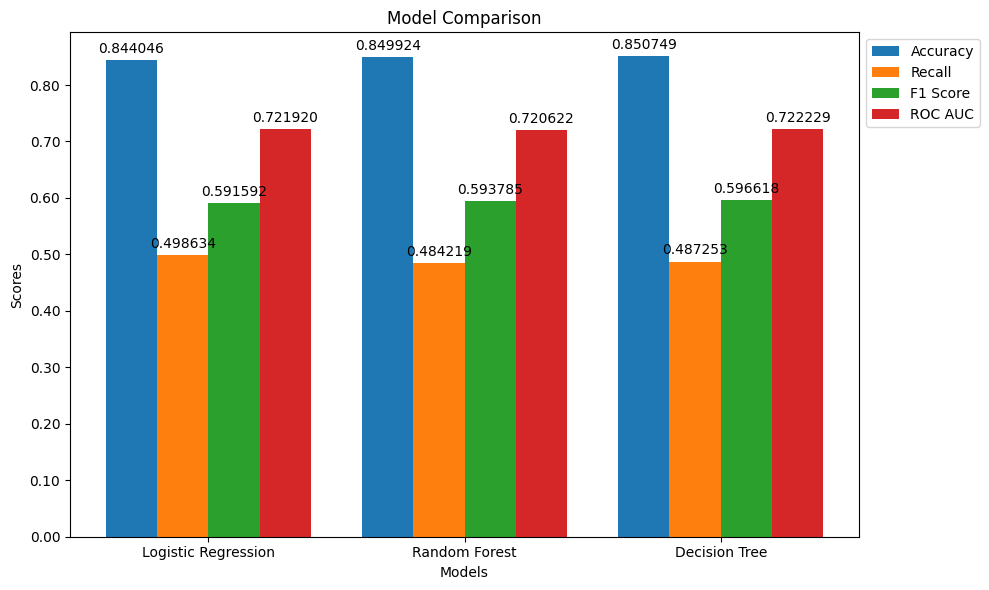

In [ ]:
# Datos
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']
accuracy = [accuracyLR, accuracyRF, accuracyDT]
recall = [recallLR, recallRF, recallDT]
f1 = [f1LR, f1RF, f1DT]
roc_auc = [roc_aucLR, roc_aucRF, roc_aucDT]

# Configurar el ancho de las barras
bar_width = 0.2
index = np.arange(len(models))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotear las barras
rects1 = ax.bar(index, accuracy, bar_width, label='Accuracy')
rects2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
rects3 = ax.bar(index + 2 * bar_width, f1, bar_width, label='F1 Score')
rects4 = ax.bar(index + 3 * bar_width, roc_auc, bar_width, label='ROC AUC')

# Configurar etiquetas y título
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)

# Configurar el formato de las etiquetas en el eje y para mayor precisión
ax.yaxis.set_major_formatter('{:.2f}'.format)

# Agregar etiquetas en la parte superior de las barras
for i, rect in enumerate(rects1 + rects2 + rects3 + rects4):
    height = rect.get_height()
    ax.annotate(f'{height:.6f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Mover la leyenda fuera de la gráfica
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Mostrar la gráfica
plt.tight_layout()  # Ajustar el diseño para evitar recorte
plt.show()


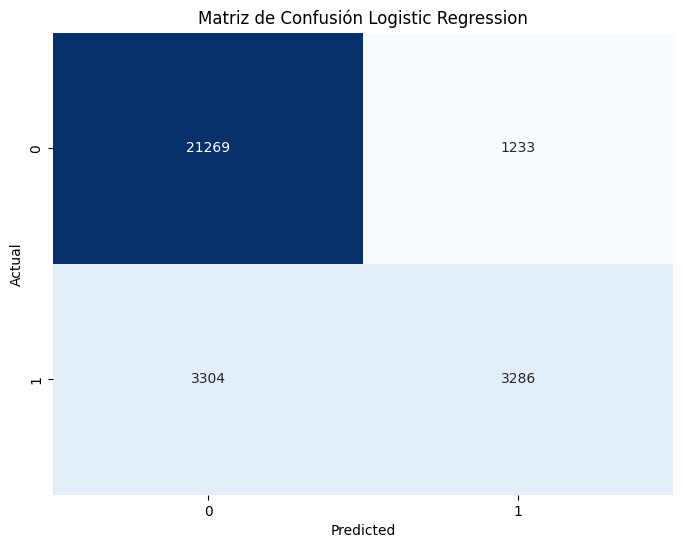

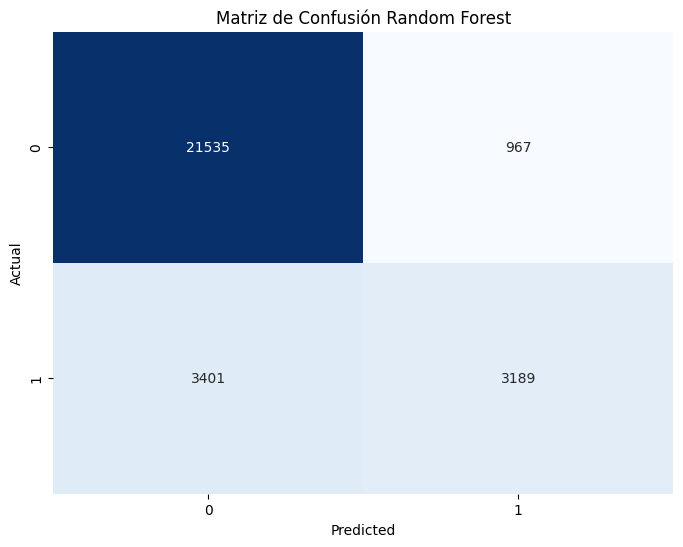

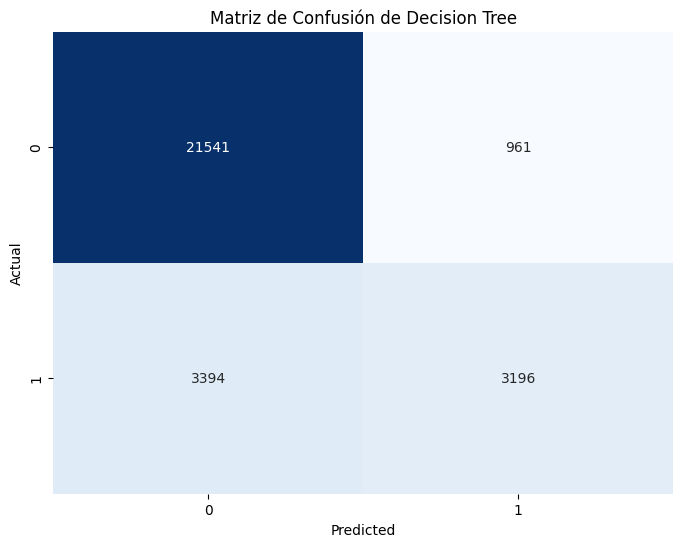

In [ ]:
# Calcular la matriz de confusión de Logistic Regression
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('\n')

# Calcular la matriz de confusión
cm = confusion_matrix(y_test1, y_pred1)

# Visualizar la matriz de confusión de Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('\n')

# Calcular la matriz de confusión de Decision Tree
cm = confusion_matrix(y_test2, y_pred2)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión de Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('\n')



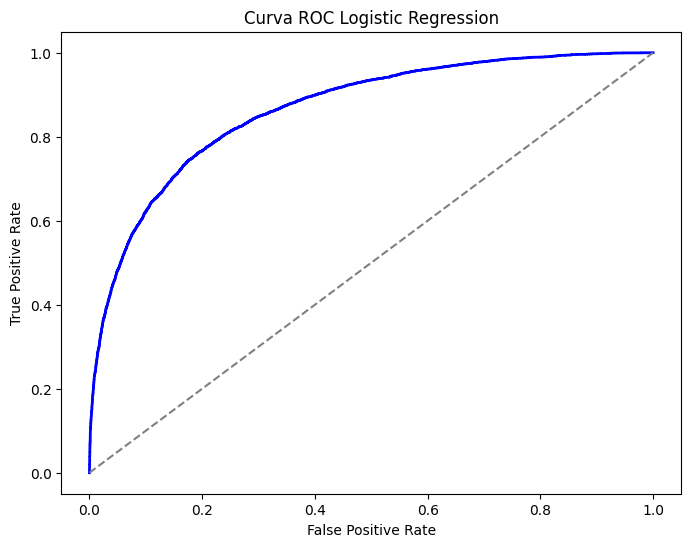

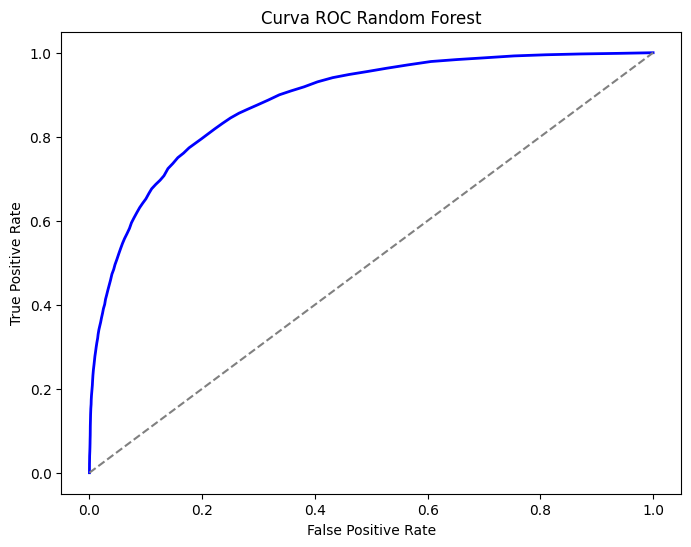

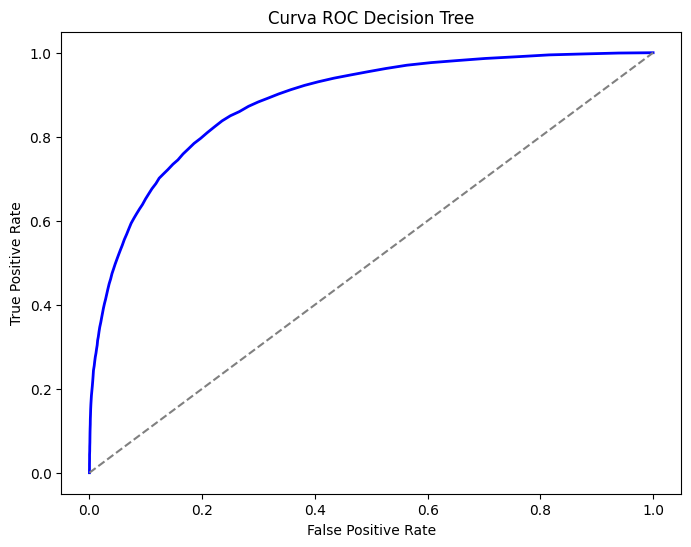

In [ ]:
# Obtener la probabilidad de predicción para la clase positiva
y_prob = pipelineLR.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Logistic Regression')
plt.show()
print('\n')

# Obtener la probabilidad de predicción para la clase positiva
y_prob1 = pipelineRF.predict_proba(X_test1)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test1, y_prob1)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest')
plt.show()
print('\n')

# Obtener la probabilidad de predicción para la clase positiva
y_prob2 = pipelineDT.predict_proba(X_test2)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test2, y_prob2)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Decision Tree')
plt.show()
print('\n')


## Selección del modelo

El modelo que elegimos, luego de analizar las métricas obtenidas, es Decision Tree. Esta decisión está fundamentada de acuerod a los siguiente:


* Precisión (Accuracy): Es la proporción de predicciones correctas entre el total
de casos. Es una buena medida general, pero puede ser engañosa si las clases están desbalanceadas.

* Recuperación (Recall): Es la proporción de casos positivos reales que fueron identificados correctamente. Es crucial si los falsos negativos son más problemáticos que los falsos positivos.

* Puntuación F1 (F1 Score): Es el promedio armónico de la precisión y la recuperación. Es útil cuando quieres un balance entre precisión y recuperación, especialmente si las clases están desbalanceadas.

* ROC AUC: Mide la capacidad del modelo para distinguir entre clases. Un valor más alto indica una mejor discriminación.


Ahora, evaluando los modelos implementados:

* Regresión Logística: Cuenta el menor valor de precisión, pero el mayor valor de ROC AUC, indicando así una mejor capacidad para distinguir entre clases.

* Bosque Aleatorio y Árbol de Decisión: Extrañamente, estos dos moedlos tienen exactamente las mismas métricas. La precisión de ambos es ligeramente superior a la regresión logística, pero su ROC AUC es marginalmente menor.

Por último, ya que el objetivo principal del proyecto es maximizar la capacidad general de predicción (precisión), el Bosque Aleatorio o el Árbol de Decisión podrían ser ligeramente mejores. Entre estos dos modelos, decidimos utilizar Árbol de Decisión

# Implementación del modelo elegido con un nuevo set de datos

Información del dataset:

Casi 30.000 canciones de la API de Spotify. Consulte el archivo Léame para obtener una tabla de diccionario de datos formateada.

Directorio de datos

| Variable               | Class    | Description                                                                                                       |
|------------------------|----------|-------------------------------------------------------------------------------------------------------------------|
| track_id               | Character| Identificador único de la canción                                                                                |
| track_name             | Character| Name of the song                                                                                                 |
| track_artist           | Character| Artist of the song                                                                                               |
| track_popularity       | Double   | Song popularity (0-100), where higher is better                                                                 |
| track_album_id         | Character| Unique identifier of the album                                                                                   |
| track_album_name       | Character| Name of the album of the song                                                                                    |
| track_album_release_date| Character| Release date of the album                                                                                        |
| playlist_name          | Character| Name of the playlist                                                                                             |
| playlist_id            | Character| Playlist identifier                                                                                             |
| playlist_genre         | Character| Playlist genre                                                                                                   |
| playlist_subgenre      | Character| Playlist subgenre                                                                                                |
| danceability           | Double   | Danceability describes how suitable a track is for dancing. 0.0 is least danceable, 1.0 is most danceable          |
| energy                 | Double   | Energy is a measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity                   |
| key                    | Double   | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation                 |
| loudness               | Double   | The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 dB                      |
| mode                   | Double   | Mode indicates the modality (major or minor) of a track. Major is represented by 1 and minor is 0                   |
| speechiness            | Double   | La speechiness detecta la presencia de palabras habladas en una pista                                              |
| acousticness           | Double   | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic |
| instrumentalness       | Double   | Predicts whether a track contains no vocals                                                                      |
| liveness               | Double   | Detects the presence of an audience in the recording                                                             |
| valence                | Double   | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track                                |
| tempo                  | Double   | The overall estimated tempo of a track in beats per minute (BPM)                                                  |
| duration_ms            | Double   | Duration of song in milliseconds                                                                                 |


## Importación de librerías

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

## EDA

In [108]:
df = pd.read_csv('/spotify_songs.csv')
df

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


Información general del dataset

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

Columnas a evaluar

In [110]:
columns = [

    'danceability',
    'energy',
    'key',
    'mode',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms'
]

df[columns].head()

,danceability,energy,key,mode,instrumentalness,liveness,valence,tempo,duration_ms
0,0.748,0.916,6,1,0.000000,0.0653,0.518,122.036,194754
1,0.726,0.815,11,1,0.004210,0.3570,0.693,99.972,162600
2,0.675,0.931,1,0,0.000023,0.1100,0.613,124.008,176616
3,0.718,0.930,7,1,0.000009,0.2040,0.277,121.956,169093
4,0.650,0.833,1,1,0.000000,0.0833,0.725,123.976,189052


Valores únicos por columna

In [111]:
for c in df[columns]:
    print(f'columna: {c}, Valores únicos: {df[c].nunique()}')

columna: danceability, Valores únicos: 822
columna: energy, Valores únicos: 952
columna: key, Valores únicos: 12
columna: mode, Valores únicos: 2
columna: instrumentalness, Valores únicos: 4729
columna: liveness, Valores únicos: 1624
columna: valence, Valores únicos: 1362
columna: tempo, Valores únicos: 17684
columna: duration_ms, Valores únicos: 19785


## Transformación de datos y selección de variable objetivo

Normalizar datos

In [112]:
var = [
    'danceability',
    'energy',
    'key',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms'
]

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[var])
scaled_df[:2]

array([[0.76093591, 0.9159853 , 0.54545455, 0.        , 0.06556225,
        0.52270434, 0.50967257, 0.37125397],
       [0.73855544, 0.81496762, 1.        , 0.00423541, 0.35843373,
        0.69929364, 0.41752422, 0.30867441]])

Separación de características y objetivo

In [113]:
# Se buscará predecir el modality de una canción, para saber si es mayor o menor


X = scaled_df
y = df['mode']

Separar datos para entrenamiento y pruebas

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamiento del modelo

In [115]:
dt_final = DecisionTreeClassifier()
dt_final.fit(X_train, y_train)

DecisionTreeClassifier()

Métricas

In [116]:
# Predecir en el conjunto de prueba
y_pred = dt_final.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Mostrar métricas
print('Decision Tree')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print('\n')



Decision Tree
Accuracy: 0.678391959798995
Recall: 0.7106785902156759
F1 Score: 0.7189994678020224
ROC AUC: 0.672337486789574




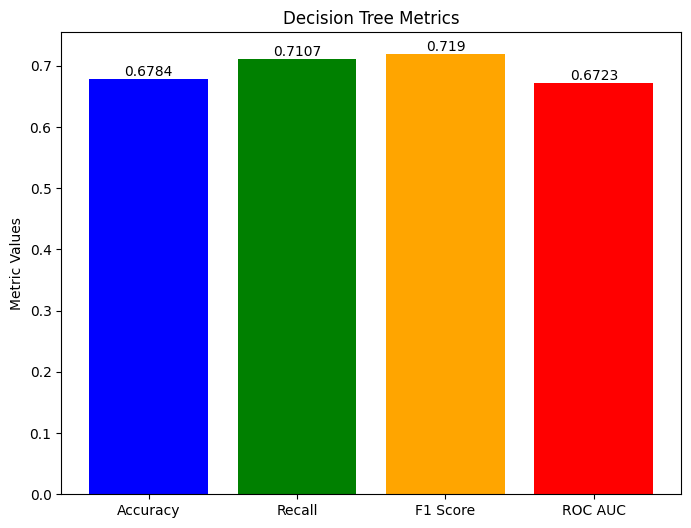

In [117]:
# Métricas
metrics = ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC']
values = [accuracy, recall, f1, roc_auc]

# Configurar el ancho de las barras
bar_width = 0.5

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Plotear las barras
bars = ax.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Agregar etiquetas en la parte superior de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Configurar el título y las etiquetas
plt.title('Decision Tree Metrics')
plt.ylabel('Metric Values')

# Mostrar la gráfica
plt.show()

Matriz de confusión

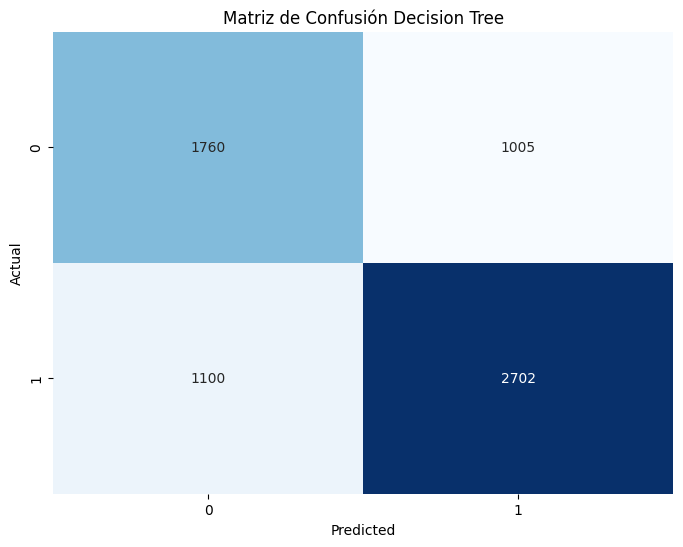

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print('\n')

Curva ROC

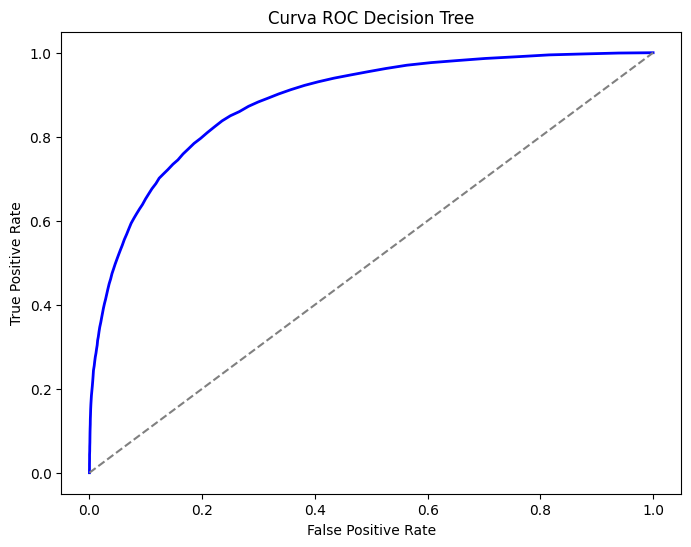

In [ ]:
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test2, y_prob2)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Decision Tree')
plt.show()
print('\n')

Visualización del árbol

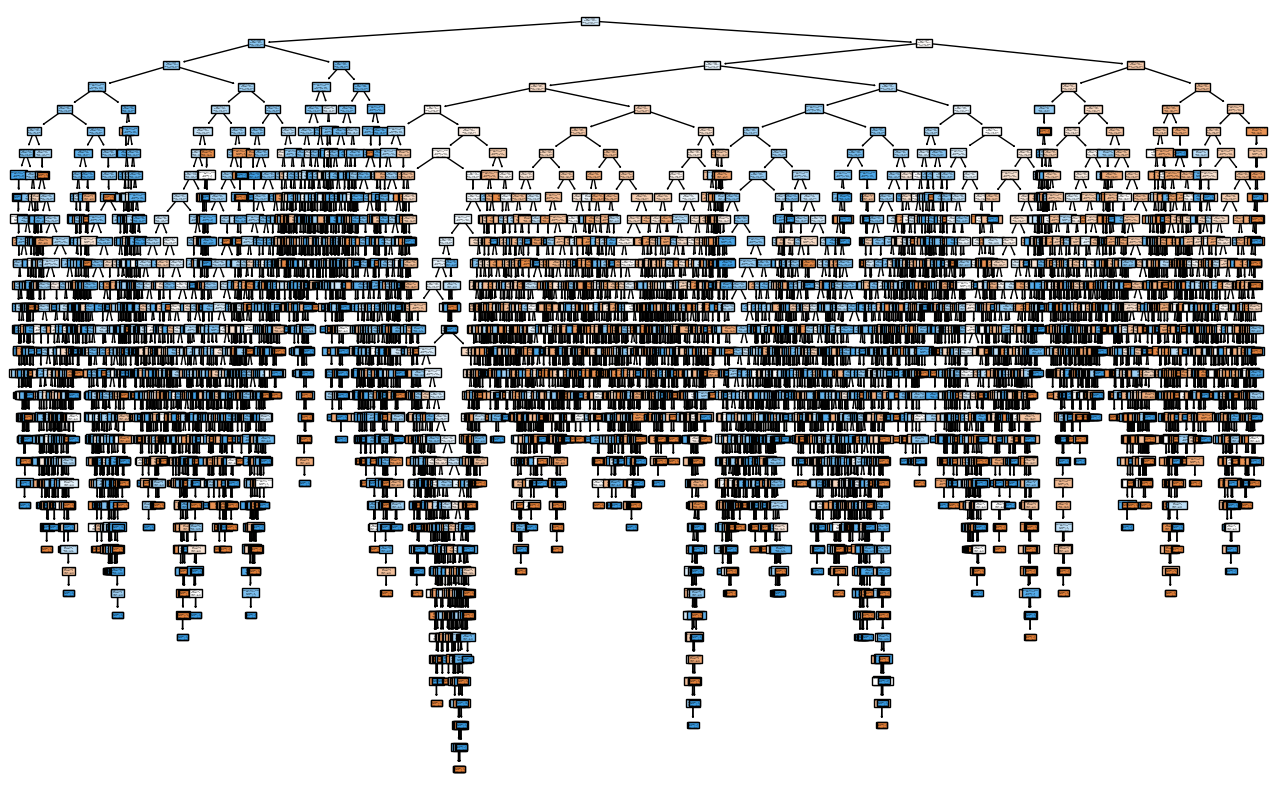

In [ ]:
plt.figure(figsize=(16,10))
tree.plot_tree(dt_final, feature_names = var,
               class_names = ['Minor', 'Major'], # Major is represented by 1 and minor is 0.
                filled=True)
plt.show()